In [1]:
import cv2
import mediapipe as mp
import os, os.path as osp
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

objc[12263]: Class CaptureDelegate is implemented in both /Users/morris/miniforge3/envs/crv2/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x16650e538) and /Users/morris/miniforge3/envs/crv2/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x163308860). One of the two will be used. Which one is undefined.
objc[12263]: Class CVWindow is implemented in both /Users/morris/miniforge3/envs/crv2/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x16650e588) and /Users/morris/miniforge3/envs/crv2/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x11d1f4a68). One of the two will be used. Which one is undefined.
objc[12263]: Class CVView is implemented in both /Users/morris/miniforge3/envs/crv2/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x16650e5b0) and /Users/morris/miniforge3/envs/crv2/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x11d1f4a90). One of the two will be used. Which one is undefined.
objc[12263]

https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md

In [2]:
RAW_DATA_PATH = osp.join(os.getcwd(), "raw_data")
TRAIN_DATA_PATH = osp.join(os.getcwd(), "x_data.npy")
TRAIN_LABEL_PATH = osp.join(os.getcwd(), "y_data.npy")

In [3]:
def draw_results(results, image):
    # Draw hand landmarks of each hand.
    annotated_image = image.copy()
    for hand_landmarks in results.multi_hand_landmarks:
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
      return annotated_image

def visualize_keypoints(results):
  for hand_world_landmarks in results.multi_hand_world_landmarks:
    mp_drawing.plot_landmarks(hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


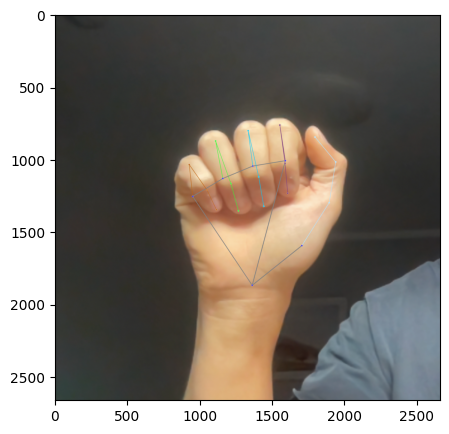

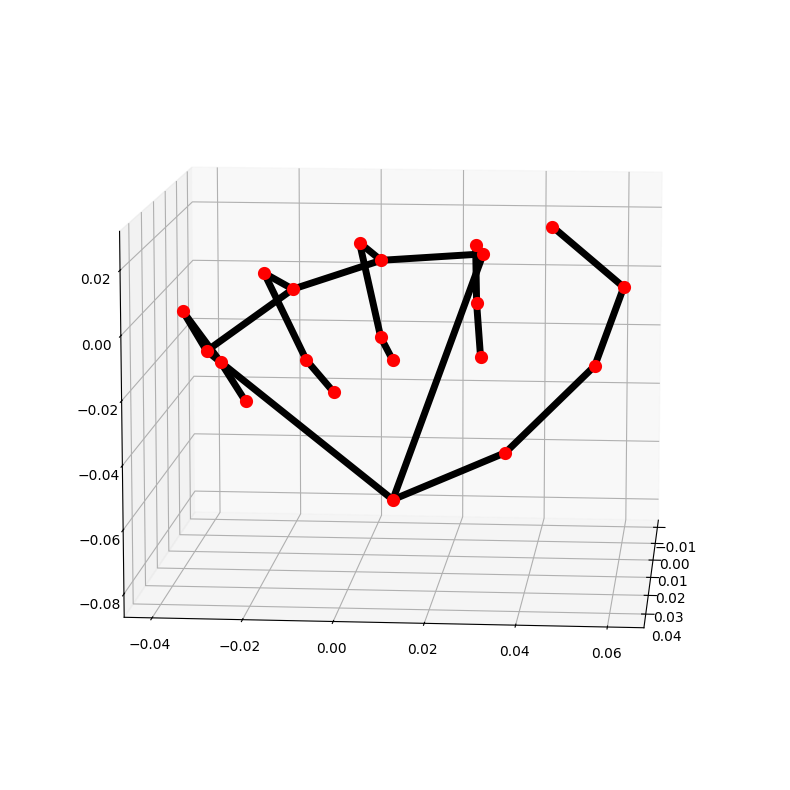

In [4]:
image_path = osp.join(os.getcwd(), "test_image.png")
im_rgb = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

with mp_hands.Hands(
static_image_mode=True,
max_num_hands=1,
min_detection_confidence=0.5) as hands:
    results = hands.process(im_rgb)

plt.rcParams["figure.figsize"] = 5, 5
annotated_image = draw_results(results, im_rgb)
plt.imshow(annotated_image)
visualize_keypoints(results)

In [ ]:
labels = []
feature_vectors = []

file_names = sorted([name for name in os.listdir(RAW_DATA_PATH) if name.endswith(".mp4") or name.endswith(".mov")])

# Initialize mp hands
with mp_hands.Hands(
static_image_mode=False,
max_num_hands=1,
min_detection_confidence=0.5) as hands:

    for file_name in tqdm(file_names):

        label = file_name[0]
        cap = cv2.VideoCapture(osp.join(RAW_DATA_PATH, file_name)) # Open file with cv2

        while(cap.isOpened()): # Loop through the frames of the video
            ret, frame = cap.read()
            if ret == False:
                break

            input = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(input) # Model inference
            
            # If a hand got detected
            if len(results.multi_handedness)>0:
                for hand_landmarks in results.multi_hand_landmarks:
                    # For each 21 keypoints, append the x, y, z coordinates
                    # to the feature vector --> len(feature_vector) = 63
                    feature_vector = []
                    for keypoint in mp_hands.HandLandmark:
                        feature_vector.append(hand_landmarks.landmark[keypoint].x)
                        feature_vector.append(hand_landmarks.landmark[keypoint].y)
                        feature_vector.append(hand_landmarks.landmark[keypoint].z)

                # Append label
                labels.append(label)
                # Append data
                feature_vectors.append(feature_vector)

        cap.release()

# Save the data
np.save('x_data.npy', np.array(feature_vectors).astype(np.float32))
np.save('y_data.npy', np.array(labels).astype('<U1'))

In [5]:
labels = np.load('./y_data.npy')
feature_vectors = np.load('./x_data.npy')

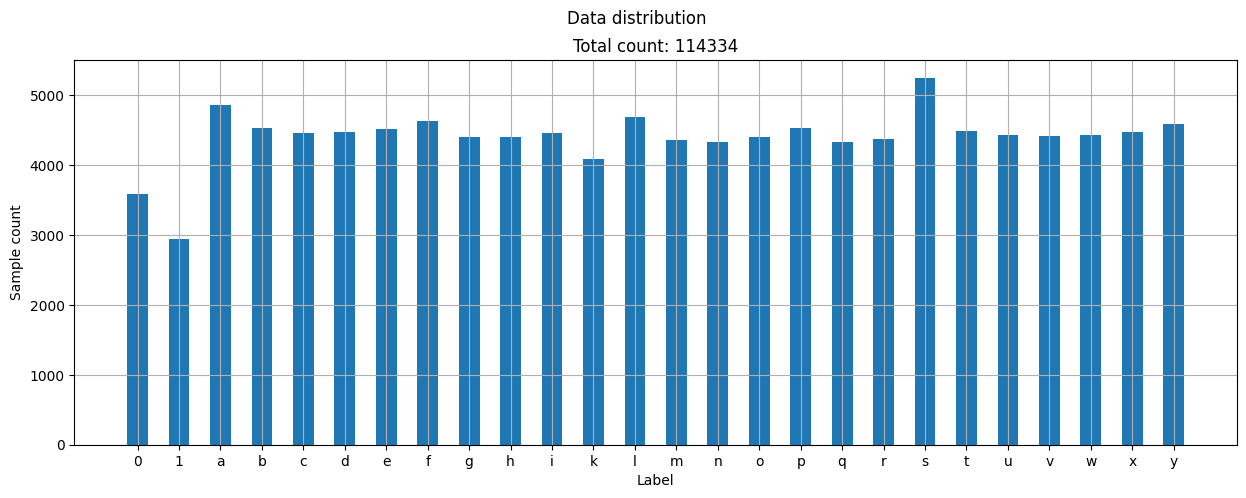

In [6]:
hist_labels = []
hist_counts = []
for label in sorted(list(set(labels))):
    hist_labels.append(label)
    hist_counts.append(list(labels).count(label))

plt.rcParams["figure.figsize"] = 15, 5
plt.bar(hist_labels, hist_counts, 0.5)
plt.grid()
plt.suptitle("Data distribution")
plt.title(f"Total count: {len(labels)}")
plt.ylabel("Sample count")
plt.xlabel("Label")
plt.show()

In [7]:
TEST_SPLIT, VALID_SPLIT = 0.1, 0.33

(X_train, X_test, y_train, y_test) = train_test_split(feature_vectors, labels, test_size =TEST_SPLIT, shuffle=True)
(X_valid, X_test, y_valid, y_test) = train_test_split(X_test, y_test, test_size=VALID_SPLIT, shuffle=True)

X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

In [8]:
def one_hot_encoding(y_labels):
    label_binarizer = LabelBinarizer()
    y_one_hot = label_binarizer.fit_transform(y_labels)
    return y_one_hot, y_labels

y_train, y_train_label = one_hot_encoding(y_train)
y_valid, y_valid_label = one_hot_encoding(y_valid)
y_test, y_test_label = one_hot_encoding(y_test)

In [42]:
"""
class_weights = {}

counts = [list(y_train_label).count(label) for label in sorted(list(set(labels)))]

for i, count in enumerate(counts):
    class_weights[i] = 1/count
print(class_weights.values())
"""

dict_values([0.00030959752321981426, 0.0003819709702062643, 0.00022988505747126436, 0.0002450379808870375, 0.00024962556165751375, 0.00025075225677031093, 0.0002453385672227674, 0.0002390628735357399, 0.00025201612903225806, 0.00025258903763576663, 0.0002467308166790032, 0.00027078256160303275, 0.00023691068467187872, 0.00025568908207619537, 0.0002594706798131811, 0.0002525252525252525, 0.0002447381302006853, 0.00025700334104343357, 0.00025484199796126404, 0.00021164021164021165, 0.00024783147459727387, 0.00025188916876574307, 0.0002519526329050139, 0.00025233409033560434, 0.0002463054187192118, 0.0002423654871546292])


In [11]:
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(2048, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256 , activation = 'relu'))
    model.add(Dropout(0.1))
    model.add(Dense(units = len(y_train[0]) , activation = 'softmax'))
    model.compile(optimizer = 'adam' , loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01) , metrics = ['accuracy'])
    model.build(input_shape=(None, *input_shape))
    model.summary()
    return model

model = build_model(input_shape=(len(X_train[1]),))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              131072    
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               5

In [12]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, baseline=0.8)
mc = tf.keras.callbacks.ModelCheckpoint('./models/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# Define the Keras TensorBoard callback.
#logdir="./logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


cb_list = [es, mc, learning_rate_reduction]#, tensorboard_callback]

In [13]:
EPOCHS = 200
BATCH_SIZE = 512

history = model.fit(X_train, y_train, shuffle=True, \
                    batch_size = BATCH_SIZE , epochs = EPOCHS , \
                        validation_data = (X_valid, y_valid), \
                            callbacks = cb_list)#, class_weight=class_weights)

Epoch 1/200


2023-10-13 21:23:12.484783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


200/201 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.5387
Epoch 1: val_accuracy improved from -inf to 0.88103, saving model to ./models/best_model.h5
201/201 [==============================] - 8s 40ms/step - loss: 0.0539 - accuracy: 0.5399 - val_loss: 0.4582 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 2/200
201/201 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.8440
Epoch 2: val_accuracy improved from 0.88103 to 0.94436, saving model to ./models/best_model.h5
201/201 [==============================] - 8s 41ms/step - loss: 0.0202 - accuracy: 0.8440 - val_loss: 0.2813 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 3/200
200/201 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.8864
Epoch 3: val_accuracy improved from 0.94436 to 0.95760, saving model to ./models/best_model.h5
201/201 [==============================] - 8s 42ms/step - loss: 0.0159 - accuracy: 0.8865 - val_loss: 0.2355 - val_accuracy: 0.9576 - lr: 0.0010
Epoc

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(np.arange(len(train_acc)) , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(np.arange(len(val_acc)) , val_acc , 'ro-' , label = 'Validation Accuracy')
#ax[0].set_yscale('log')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].grid(visible=True)


ax[1].plot(np.arange(len(train_loss)) , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(np.arange(len(val_loss)) , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].grid(visible=True)
#ax[1].set_yscale('log')

plt.savefig('./history_00.png', dpi=600)
plt.show()

In [15]:
saved_model = load_model('./models/best_model.h5')

In [16]:
predictions = saved_model(X_test, training=False)
predictions = np.argmax(predictions, axis=1)

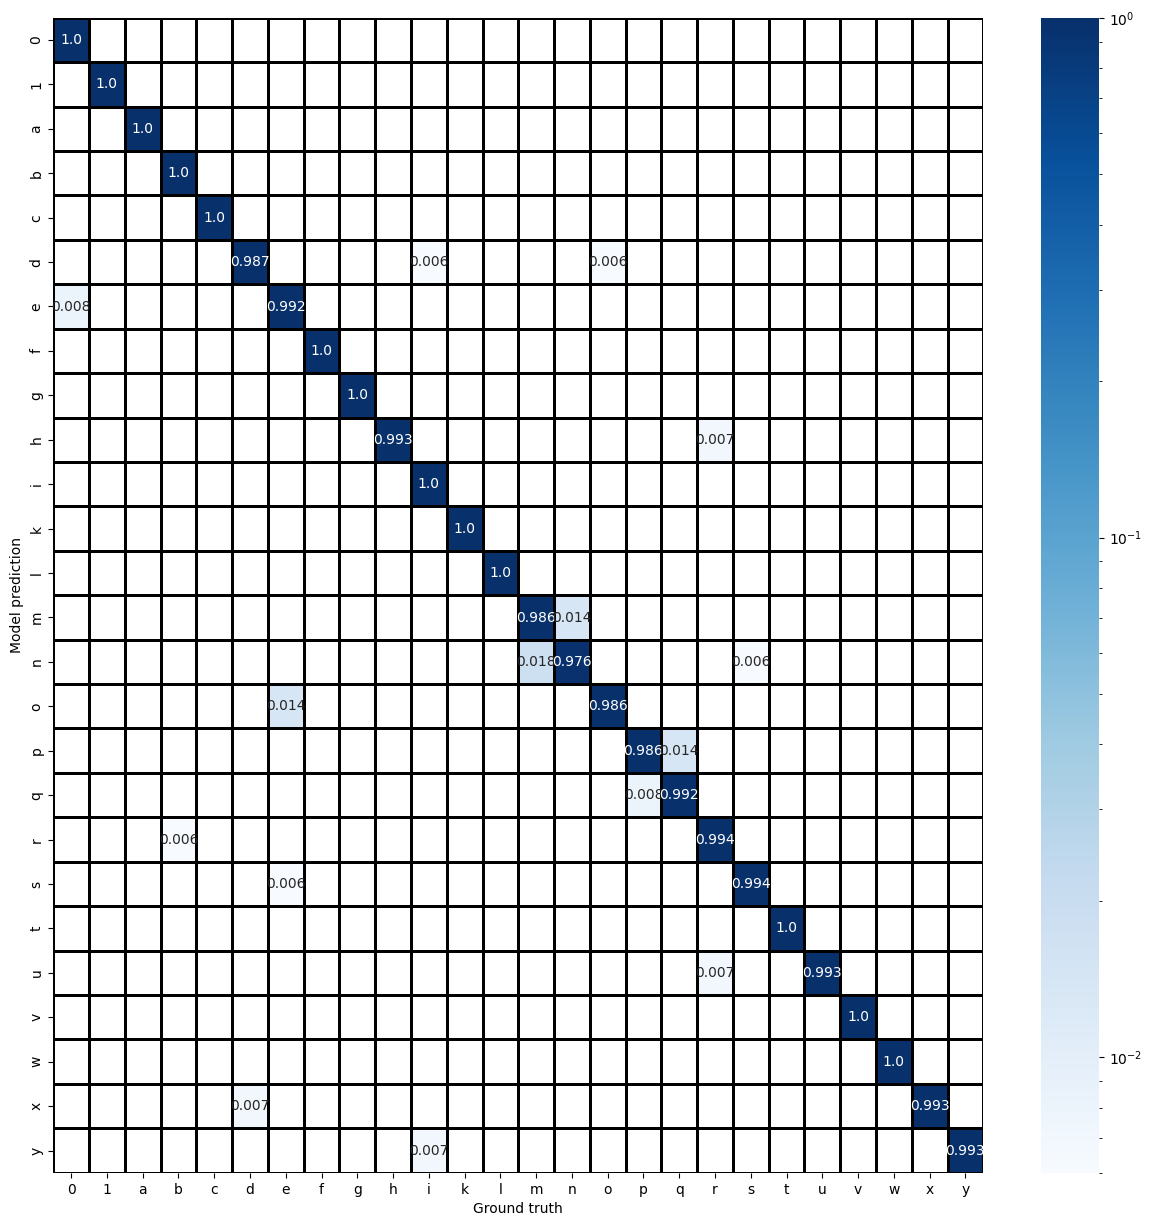

Test accuracy: 0.994700582935877


In [26]:
plt.rcParams["figure.figsize"] = 15, 15

label_names = np.array(sorted(list(set(y_test_label))))

cm = confusion_matrix(y_test_label,label_names[predictions], normalize='true')
cm = pd.DataFrame(cm , index = [i for i in range(len(y_train[0]))] , columns = [i for i in range(len(y_train[0]))])
cm = round(cm,3)
g = sns.heatmap(cm, cmap= "Blues", norm=LogNorm(), linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
g.set(xticklabels=label_names, yticklabels=label_names, xlabel="Ground truth", ylabel="Model prediction")
plt.show()

print(f"Test accuracy: {np.mean(y_test_label==label_names[predictions])}")